In [7]:
import pandas as pd
from sklearn.preprocessing import MaxAbsScaler

# read datasets
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

y1_name, y2_name, y3_name = "dir_costs", "traffic_costs_s_r", "lost_trips_costs_s_r"
train_y1, train_y2, train_y3 = train_df[y1_name], train_df[y2_name], train_df[y3_name]
test_y1, test_y2, test_y3 = test_df[y1_name], test_df[y2_name], test_df[y3_name]

# scale features
X_train = train_df.drop(columns=[y1_name, y2_name, y3_name])
scaler = MaxAbsScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

X_test = test_df.drop(columns=[y1_name, y2_name, y3_name])
X_test_scaled = scaler.transform(X_test)


<h2> Figure out optimal number of clusters </h2>

<h3> Elbow method </h3>

/home/lavuna47/Projects/Diploma/venv/lib64/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/lavuna47/Projects/Diploma/venv/lib64/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/lavuna47/Projects/Diploma/venv/lib64/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/lavuna47/Projects/Diploma/venv/lib64/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416:

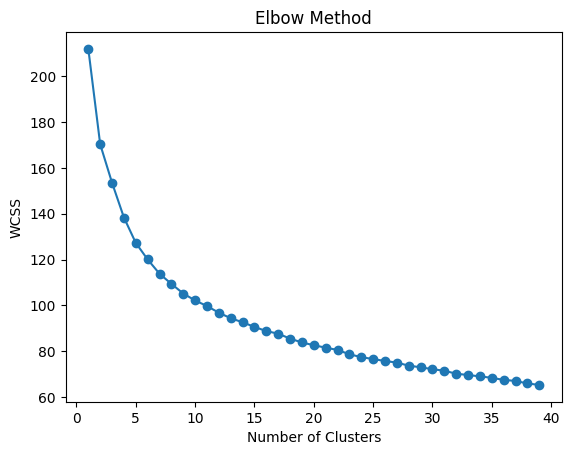

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define a range of cluster numbers
cluster_range = range(1, 40)
wcss = []

# Calculate WCSS for each cluster number
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X_train_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow method graph
plt.plot(cluster_range, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

<h3> Silhouette Method </h3>

In [ ]:
# TODO: 

In [67]:
from sklearn.cluster import KMeans

clusters_num = 2
kmeans = KMeans(n_clusters=clusters_num, random_state=42, n_init=10)
kmeans.fit(X_train_scaled)

KMeans(n_clusters=2, n_init=10, random_state=42)

In [68]:
import numpy as np
# transforms X into clustered dataset with. k - number of clusters in the range [0, k-1]
def transform_to_clustered_dataset(X: np.ndarray, cluster_predictor, k: int):
    clusters = cluster_predictor.predict(X)
    zero_columns = pd.DataFrame(np.zeros((X.shape[0], k)), columns=[f'class_{i}' for i in range(k)])
    res = np.concatenate((X, zero_columns), axis=1)
    for i in range(res.shape[0]):
        cluster = clusters[i]
        res[i, X.shape[1] + cluster] = 1.0 
    return res

In [69]:
X_train_scaled_clustered = transform_to_clustered_dataset(X_train_scaled, kmeans, clusters_num)
X_test_scaled_clustered = transform_to_clustered_dataset(X_test_scaled, kmeans, clusters_num)

<h2> Pick sigma from unclustered dataset <h2>


In [70]:
from GRNN import GRNN
from metrics import print_metrics

grnn_y1 = GRNN(sigma=0.066551824)
grnn_y1.fit(X_train_scaled_clustered, train_y1)

print("------ test metrics ------")
print_metrics(test_y1, grnn_y1.predict(X_test_scaled_clustered))


------ test metrics ------
Mean Squared Error (MSE):              38176679135730.6640625000
Root Mean Squared Error (RMSE):        6178727.9545008829
Mean Absolute Error (MAE):             4134095.2360935365
R-squared (R²):                        0.8016058666
Mean Absolute Percentage Error (MAPE): 0.1062833841
Max Error (ME):                        27734505.1958923936
Median Absolute Error (MedAE):         2661720.9337386414


<h2> Optimize sigma with differential evolution<h2>

In [71]:
from sklearn.metrics import r2_score
from scipy.optimize import differential_evolution

# define objective function
def objective_function(sigma, train_X, train_y, test_X, test_y):
    grnn = GRNN(sigma=sigma[0])
    grnn.fit(train_X, train_y)
    pred_y = grnn.predict(test_X)
    r2 = r2_score(test_y, pred_y)
    return -r2


<h1> Y1 </h1>

In [72]:
optimization_res = differential_evolution(func=objective_function, 
                                          bounds=[(0, 10)], 
                                          updating='deferred',
                                          workers=10, 
                                          disp=True,
                                          tol=0.0000001,
                                          atol=0.0000001,
                                          args=(X_train_scaled_clustered, train_y1, X_test_scaled_clustered, test_y1))
print(optimization_res)
print("Optimal sigma_y1: {:.{}f}".format(optimization_res.x[0], 9))

differential_evolution step 1: f(x)= -0.790328
differential_evolution step 2: f(x)= -0.790328
differential_evolution step 3: f(x)= -0.790328
differential_evolution step 4: f(x)= -0.790328
differential_evolution step 5: f(x)= -0.800635
differential_evolution step 6: f(x)= -0.800635
differential_evolution step 7: f(x)= -0.800635
differential_evolution step 8: f(x)= -0.801592
differential_evolution step 9: f(x)= -0.801592
differential_evolution step 10: f(x)= -0.801592
differential_evolution step 11: f(x)= -0.801592
differential_evolution step 12: f(x)= -0.801592
differential_evolution step 13: f(x)= -0.801592
differential_evolution step 14: f(x)= -0.801606
differential_evolution step 15: f(x)= -0.801606
differential_evolution step 16: f(x)= -0.801606
differential_evolution step 17: f(x)= -0.801606
differential_evolution step 18: f(x)= -0.801606
differential_evolution step 19: f(x)= -0.801606
differential_evolution step 20: f(x)= -0.801606
differential_evolution step 21: f(x)= -0.801606
d

In [74]:
from GRNN import GRNN
from metrics import print_metrics

grnn_y1 = GRNN(sigma=0.066551824)
grnn_y1.fit(X_train_scaled_clustered, train_y1)

print("------ test metrics ------")
print_metrics(test_y1, grnn_y1.predict(X_test_scaled_clustered))


------ test metrics ------
Mean Squared Error (MSE):              38176679135730.6640625000
Root Mean Squared Error (RMSE):        6178727.9545008829
Mean Absolute Error (MAE):             4134095.2360935365
R-squared (R²):                        0.8016058666
Mean Absolute Percentage Error (MAPE): 0.1062833841
Max Error (ME):                        27734505.1958923936
Median Absolute Error (MedAE):         2661720.9337386414


<h1> Y2 </h1>

In [75]:
optimization_res = differential_evolution(func=objective_function, 
                                          bounds=[(0, 10)], 
                                          updating='deferred',
                                          workers=10, 
                                          disp=True,
                                          tol=0.0000001,
                                          atol=0.0000001,
                                          args=(X_train_scaled_clustered, train_y2, X_test_scaled_clustered, test_y2))
print(optimization_res)
print("Optimal sigma_y2: {:.{}f}".format(optimization_res.x[0], 9))

differential_evolution step 1: f(x)= -0.688434
differential_evolution step 2: f(x)= -0.688434
differential_evolution step 3: f(x)= -0.688434
differential_evolution step 4: f(x)= -0.688434
differential_evolution step 5: f(x)= -0.688434
differential_evolution step 6: f(x)= -0.688434
differential_evolution step 7: f(x)= -0.688434
differential_evolution step 8: f(x)= -0.698796
differential_evolution step 9: f(x)= -0.699197
differential_evolution step 10: f(x)= -0.699197
differential_evolution step 11: f(x)= -0.699197
differential_evolution step 12: f(x)= -0.699197
differential_evolution step 13: f(x)= -0.699217
differential_evolution step 14: f(x)= -0.699217
differential_evolution step 15: f(x)= -0.699217
differential_evolution step 16: f(x)= -0.69922
differential_evolution step 17: f(x)= -0.69922
differential_evolution step 18: f(x)= -0.69922
differential_evolution step 19: f(x)= -0.69922
differential_evolution step 20: f(x)= -0.69922
differential_evolution step 21: f(x)= -0.69922
differe

In [77]:
from GRNN import GRNN
from metrics import print_metrics

grnn_y2 = GRNN(sigma=0.058945612)
grnn_y2.fit(X_train_scaled_clustered, train_y2)

print("------ test metrics ------")
print_metrics(test_y2, grnn_y2.predict(X_test_scaled_clustered))

------ test metrics ------
Mean Squared Error (MSE):              69229110213641.2109375000
Root Mean Squared Error (RMSE):        8320403.2482591374
Mean Absolute Error (MAE):             4517112.7109113233
R-squared (R²):                        0.6992202954
Mean Absolute Percentage Error (MAPE): 1.6853092382
Max Error (ME):                        85349653.7090934813
Median Absolute Error (MedAE):         2765921.3768472159
